# Model K

This is a script showing results of **model K** in the ablation studies. The model is built using the following configuration:

- **Backbone:** GATv2
- **Graph type:** Homogeneous
- **Loss function:** Bayesian personalized ranking
- **Embeddings used:** weighted average
- **Keyword popularity used:** Yes

*This model upgrades the state-of-the-art graph neural network methodology with novel graph transformer approach.*

## **Setting up environment**

---



### Loading libraries

In [1]:
import os
import sys

sys.path.insert(0, os.path.abspath(".."))

import torch
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from typing import Optional

from torch import Tensor
from torch.nn import ModuleList
from torch.optim import Optimizer
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.nn.conv import TransformerConv
from torch.optim.lr_scheduler import LRScheduler

from torch_geometric.data import Data

from util.torch_geometric import get_results
from util.homogeneous.dataset import (DatasetEuCoHM, load_dataset)
from util.homogeneous.model import ModelEuCoHM
from util.homogeneous.train import (
    train,
    test,
    evaluate
)

### Global variables

In [2]:
# Model name
model_name = 'K'
# Dataset save filepath
dataset_save_filepath_prefix = '../data/dataset_homogeneous_periodical_decay_top_keywords'
# Device name
device = 'cpu'

# Model configuration
model_config = dict(
    hidden_channels=128,
    learning_rate=1e-3,
    num_layers=4,
    num_epochs=50,
    num_recommendations=10,
    num_bootstrap=10
)
# Set seaborn theme
sns.set_theme(style="whitegrid", palette="pastel")

## Model training


---



### Model definition

In [3]:
class ModelEuCoK(ModelEuCoHM):
    def __init__(self,
                 input_channels: int,
                 hidden_channels: int,
                 num_layers: int,
                 num_recommendations: int,
                 author_node_id_map: dict,
                 author_id_map: dict,
                 device: str = 'cpu'):
        super().__init__(
            input_channels=input_channels,
            hidden_channels=hidden_channels,
            num_layers=num_layers,
            num_recommendations=num_recommendations,
            author_node_id_map=author_node_id_map,
            author_id_map=author_id_map,
            device=device
        )

### Training the model

In [4]:
def load_model(data: Data, model_config: dict, author_node_id_map: dict, author_id_map: dict):
    # Initialize the model
    model = ModelEuCoK(
        input_channels=data.num_features,
        hidden_channels=model_config['hidden_channels'],
        num_recommendations=model_config['num_recommendations'],
        num_layers=model_config['num_layers'],
        author_node_id_map=author_node_id_map,
        author_id_map=author_id_map
    ).to(device)
    
    # Initialize the optimizer
    optimizer: Optimizer = torch.optim.Adam(
        params=model.parameters(),
        lr=model_config['learning_rate']
    )
    
    # Initialize the scheduler
    scheduler: LRScheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=optimizer,
        mode='min',
        factor=0.5,
        patience=10
    )
    
    return model, data, optimizer, scheduler

In [5]:
results: list = list()
for bootstrap_id in range(model_config['num_bootstrap']):
    print(f'Processing bootstrap dataset ix={bootstrap_id}...')
    dataset_filepath = f'{dataset_save_filepath_prefix}_b{bootstrap_id}.pkl'
    data, author_id_map, author_node_id_map = load_dataset(dataset_filepath=dataset_filepath, device=device)
    model, data, optimizer, scheduler = load_model(data, model_config, author_node_id_map, author_id_map)
    for epoch in range(1, model_config['num_epochs'] + 1):
        # ------ Train
        train_loss: float = train(
            model=model,
            data=data,
            optimizer=optimizer
        )
        # ------ Test
        test_loss: float = test(
            model=model,
            data=data
        )
        scheduler.step(test_loss)
        # ------ Evaluate
        evaluation_results: dict = evaluate(
            k=model_config['num_recommendations'],
            model=model,
            data=data
        )
    
        # Save results
        epoch_result = get_results(
            epoch=epoch,
            train_loss=train_loss,
            test_loss=test_loss,
            evaluation_results=evaluation_results,
            bootstrap_id=bootstrap_id,
            log_every_n_epochs=10
        )
        results.append(epoch_result)

Processing bootstrap dataset ix=0...


/home/eucollab/eutopia-colllaboration/ecr-recommender/.venv/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.loa

Epoch 10, train loss: 0.0028, test loss: 0.1090, precision@k: 0.0576, recall@k: 0.1773, MAP@k: 0.0854, MRR@k: 0.1367, NDCG@k: 0.1257, HitRate@k: 0.2953
Epoch 20, train loss: 0.0023, test loss: 0.1059, precision@k: 0.0603, recall@k: 0.1889, MAP@k: 0.0911, MRR@k: 0.1458, NDCG@k: 0.1337, HitRate@k: 0.3120
Epoch 30, train loss: 0.0017, test loss: 0.1064, precision@k: 0.0622, recall@k: 0.1937, MAP@k: 0.0922, MRR@k: 0.1467, NDCG@k: 0.1360, HitRate@k: 0.3186
Epoch 40, train loss: 0.0016, test loss: 0.1028, precision@k: 0.0638, recall@k: 0.2017, MAP@k: 0.0951, MRR@k: 0.1507, NDCG@k: 0.1405, HitRate@k: 0.3291
Epoch 50, train loss: 0.0017, test loss: 0.1010, precision@k: 0.0647, recall@k: 0.2061, MAP@k: 0.0974, MRR@k: 0.1529, NDCG@k: 0.1435, HitRate@k: 0.3354
Processing bootstrap dataset ix=1...
Epoch 10, train loss: 0.0028, test loss: 0.0912, precision@k: 0.0570, recall@k: 0.1778, MAP@k: 0.0853, MRR@k: 0.1366, NDCG@k: 0.1257, HitRate@k: 0.2979
Epoch 30, train loss: 0.0019, test loss: 0.0910, pr

### Model evaluation

In [6]:
results_df = pd.DataFrame(results)
results_df.to_csv(f'../results/results_Model_bootstrapped_{model_name}.csv', index=False)

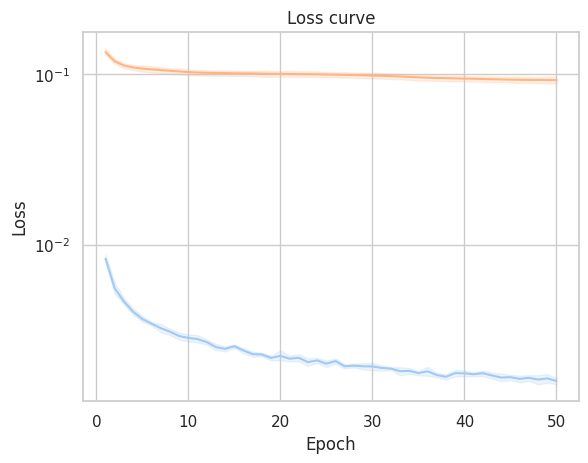

In [7]:
# Generate loss curve
# Train loss
sns.lineplot(data=results_df, x='Epoch', y='Train Loss')
# Test loss
sns.lineplot(data=results_df, x='Epoch', y='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss curve')
plt.yscale('log')
plt.show()

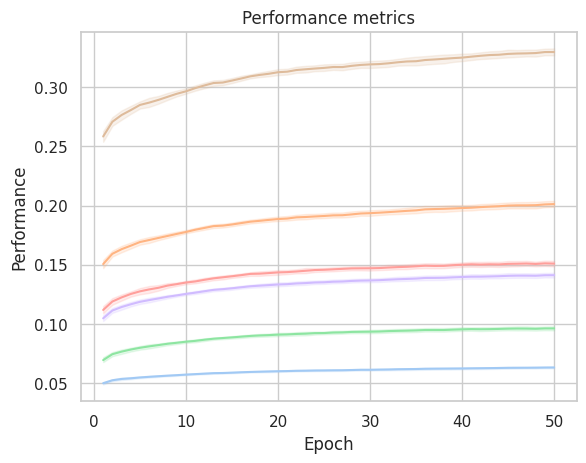

In [8]:
# Generate evaluation metrics plot
sns.lineplot(data=results_df, x='Epoch', y='Precision@k')
sns.lineplot(data=results_df, x='Epoch', y='Recall@k')
sns.lineplot(data=results_df, x='Epoch', y='MAP@k')
sns.lineplot(data=results_df, x='Epoch', y='MRR@k')
sns.lineplot(data=results_df, x='Epoch', y='NDCG@k')
sns.lineplot(data=results_df, x='Epoch', y='HitRate@k')
plt.xlabel('Epoch')
plt.ylabel('Performance')
plt.title('Performance metrics')
plt.show()